# **Architecture Likeness Elucidator (ALE) - Segundo Modelo**

## Import Libraries

In [1]:
# Standard libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import json
import itertools
import glob
import sys
import requests
import random
import pickle
import joblib
import imageio
import PIL
from tabulate import tabulate
from pathlib import Path
from PIL import ImageFont, Image

# Machine learning libraries
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from skimage.transform import resize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Conv2D, Dense, Flatten, MaxPooling2D, AveragePooling2D, Reshape
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

## Create Training and Validating Datasets

In [2]:
styles = ['Achaemenid architecture','American craftsman style','American Foursquare architecture','Ancient Egyptian architecture','Art Deco architecture',
    'Art Nouveau architecture','Baroque architecture','Bauhaus architecture','Beaux-Arts architecture','Byzantine architecture',
    'Chicago school architecture','Colonial architecture','Deconstructivism','Edwardian architecture','Georgian architecture',
    'Gothic architecture','Greek Revival architecture','International style','Novelty architecture','Palladian architecture',
    'Postmodern architecture','Queen Anne architecture','Romanesque architecture','Russian Revival architecture','Tudor Revival architecture']

numStyles = len(styles)

print(numStyles)

25


In [3]:
# Separate image dataset into features and labels (target = style)
X = []
y = []

# Set size for images to be resized to
size = (256, 256)

# Put images in X and their labels in y
for style in styles[:]:
    img_file = glob.glob(f'../data/architectural-styles-dataset/**/{style}/*.jpg', recursive = True)
    
    # Resize and grayscale each image
    for i, f in enumerate(img_file):
        img = cv2.imread(f)
        img = cv2.resize(img, size, interpolation = cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = np.array(img)
        img = img.astype('float32')
        img /= 255 
        X.append(img)
        y.append(style)

In [4]:
# Cast labels to integers 
y = [styles.index(label) for label in y]

# Create training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2)

In [5]:
# Display length of X and y
# Should be the same and reflect number of images from dataset
print(f'Length of X: {len(X)}')
print(f'Length of y: {len(y)}')

Length of X: 10113
Length of y: 10113


In [6]:
# Check lengths of training, validation, and test sets
print("Length of X_train: ", len(X_train))
print("Length of y_train: ", len(y_train))
print("Length of X_valid: ", len(X_valid))
print("Length of y_valid: ", len(y_valid))
print("Length of X_test: ", len(X_test))
print("Length of y_test: ", len(y_test))

Length of X_train:  6472
Length of y_train:  6472
Length of X_valid:  1618
Length of y_valid:  1618
Length of X_test:  2023
Length of y_test:  2023


In [7]:
# Make sets arrays for model fitting
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_valid = np.asarray(X_valid)
y_valid = np.asarray(y_valid)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

type(X_train), type(y_train)

(numpy.ndarray, numpy.ndarray)

## Create and train model

In [8]:
# Create function for LeNet-5 CNN model
def lenet5():
    model = Sequential()
    model.add(Reshape((256, 256, 1), input_shape=(256, 256), name='Reshape'))
    model.add(Conv2D(input_shape=(32, 32, 1), filters=6, kernel_size=(5, 5), strides=(1, 1), padding="same", activation='tanh', name='Conv2D_1'))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='AvgPool2D_1'))
    model.add(Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), padding='valid', activation='tanh', name='Conv2D_2'))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='AvgPool2D_2'))
    model.add(Flatten(name='Flatten'))
    model.add(Dense(120, activation='tanh', name='Dense_1'))
    model.add(Dense(84, activation='tanh', name='Dense_2'))
    model.add(Dense(25, activation='softmax', name='Dense_3'))
    return model

# Assign LeNet-5
LeNet5 = lenet5()

# View summary for LeNet-5
print(LeNet5.summary(line_length = 120))

c:\Users\ivanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\ivanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ Reshape (Reshape)                                   │ (None, 256, 256, 1)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ Conv2D_1 (Conv2D)                                   │ (None, 256, 256, 6)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ AvgPool2D_1 (AveragePooling2D)                      │ (None, 128, 128, 6)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ Conv2D_2 (Conv2D)                                   │ (None, 124, 124, 16)                   │                 2,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ AvgPool2D_2 (AveragePooling2D)                      │ (None, 62, 62, 16)                     │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ Flatten (Flatten)                                   │ (None, 61504)                          │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ Dense_1 (Dense)                                     │ (None, 120)                            │             7,380,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ Dense_2 (Dense)                                     │ (None, 84)                             │                10,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ Dense_3 (Dense)                                     │ (None, 25)                             │                 2,
└─────────────────────────────────────────────────────┴────────────────────────────────────────┴───────────────────

 Total params: 7,395,461 (28.21 MB)

 Trainable params: 7,395,461 (28.21 MB)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
# Define optimizer and loss function for LeNet-5
lenet5_early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 1, patience = 2)
lenet5_opt = SGD(learning_rate = 0.01, momentum = 0.0, nesterov = 'False')
lenet5_loss = SparseCategoricalCrossentropy()

# Compile LeNet-5 CNN model
LeNet5.compile(loss = lenet5_loss, optimizer = lenet5_opt, metrics = ['accuracy'])

# Train LeNet-5 on training set and validate with validation set
lenet5_history = LeNet5.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 15, shuffle = True, callbacks = lenet5_early_stop)

Epoch 1/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step - accuracy: 0.0700 - loss: 3.1990 - val_accuracy: 0.0964 - val_loss: 3.0814
Epoch 2/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 26s 128ms/step - accuracy: 0.1328 - loss: 2.9835 - val_accuracy: 0.1323 - val_loss: 2.9878
Epoch 3/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 25s 125ms/step - accuracy: 0.1710 - loss: 2.8781 - val_accuracy: 0.1391 - val_loss: 2.9664
Epoch 4/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step - accuracy: 0.1908 - loss: 2.7928 - val_accuracy: 0.1366 - val_loss: 2.9830
Epoch 5/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step - accuracy: 0.2347 - loss: 2.6612 - val_accuracy: 0.1434 - val_loss: 2.9832
Epoch 6/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step - accuracy: 0.2990 - loss: 2.4819 - val_accuracy: 0.1459 - val_loss: 3.0197
Epoch 7/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step - accuracy: 0.3921 - loss: 2.2591 - val_accuracy: 0.1446 - val_loss: 3.0706
Epoch 8/15
203/203 ━━━━━━━━━━━━━━━━━━━━ 25s 125ms/step - accuracy: 0.5006 - loss: 1

In [10]:
# Evaluate loss and accuracy from test set
LeNet5.evaluate(X_test, y_test)

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.1364 - loss: 3.1696


[3.160737991333008, 0.14483439922332764]

In [11]:
# Save model
LeNet5.save('LeNet5.h5')

In [12]:
# Load model (for when the same kernel instance isn't in use)
LeNet5 = load_model('LeNet5.h5')

In [13]:
# Save the history (fit) of model
with open('LeNet5TrainingHistory', 'wb') as file:
    pickle.dump(lenet5_history.history, file)

In [14]:
# Load saved history (fit) of model (for when the same kernel instance isn't in use)
with open('LeNet5TrainingHistory', "rb") as file:
    lenet5_history = pickle.load(file)

## Test model with different images

In [15]:
# Make prediciton on first image in test set
lenet5_pred = LeNet5.predict(X_test)
lenet5_pred[0]

# Print a quick comparison of the predicted label vs actual label of first test sample
print(f'Predicted encoded label of first test sample: {np.argmax(lenet5_pred[0])}')
print(f'Actual encoded label of first test sample: {y_test[0]}')

# Max prediction of each label for each image
lenet5_y_pred = np.argmax(lenet5_pred, axis = 1)

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
Predicted encoded label of first test sample: 6
Actual encoded label of first test sample: 23


Text(0.5, 0.98, 'LeNet5 Test Dataset Predictions')

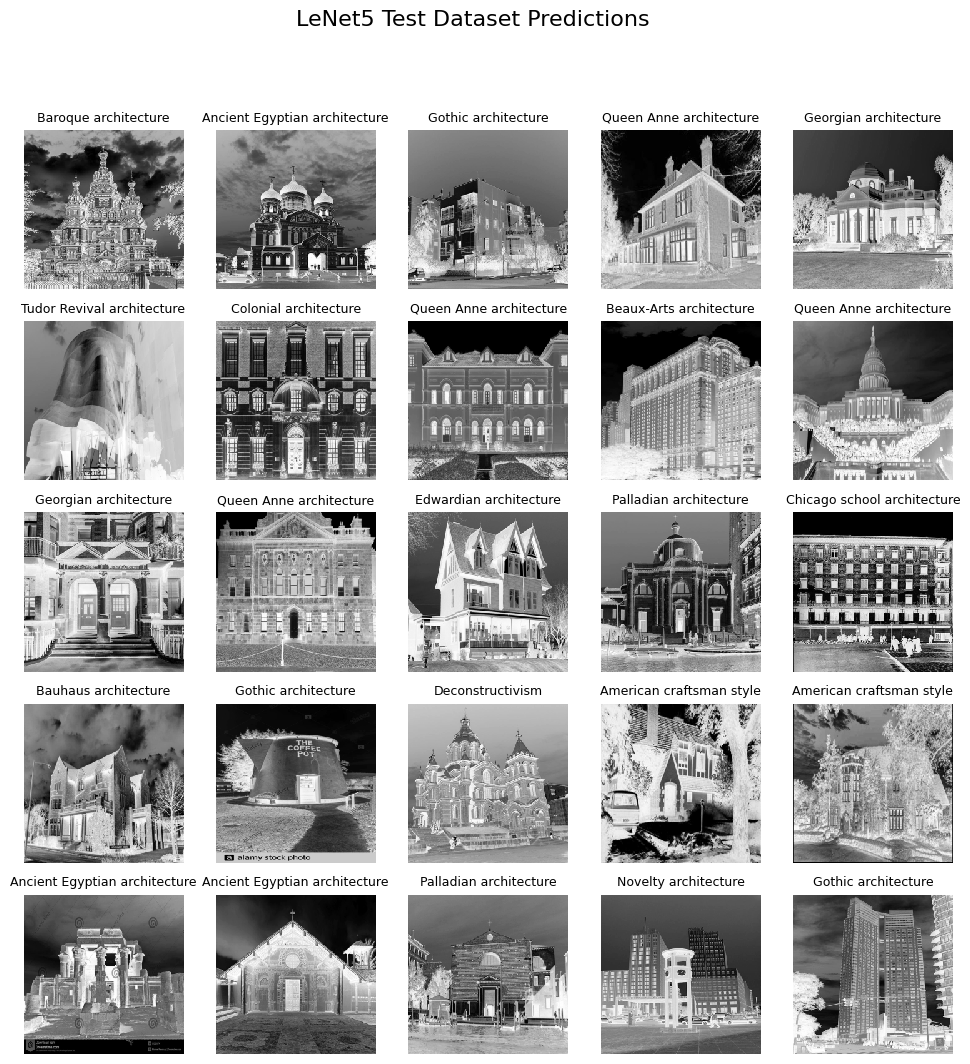

In [16]:
# Display first 25 images from test set and the predicted label
fig, ax = plt.subplots(ncols = 5, nrows = 5, figsize = (12, 12))
ax = ax.flatten()

for i, img in enumerate(X_test[:25]):
    ax[i].axis('off')
    ax[i].imshow(img, cmap = "binary", interpolation = "nearest")
    ax[i].set_title(styles[lenet5_y_pred[i]], fontsize = 9)

fig.suptitle('LeNet5 Test Dataset Predictions', fontsize = 16)